In [6]:
from scipy.integrate import odeint 
import time
import numpy as np
from math import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
import numpy as np
from matplotlib import pyplot as plt
import random

In [7]:
m1 = 2                 # mass of pendulum 1 (in kg)
m2 = 1                 # mass of pendulum 2 (in kg)
L1 = 1.4                 # length of pendulum 1 (in meter)
L2 = 1                 # length of pendulum 2 (in meter)
g = 9.8                # gravitatioanl acceleration constant (m/s^2)

L1 = tf.cast(L1,dtype=tf.float32)
L2 = tf.cast(L2,dtype=tf.float32)
m1 = tf.cast(m1,dtype=tf.float32)
m2 = tf.cast(m2,dtype=tf.float32)
g = tf.cast(g,dtype=tf.float32)

In [3]:
u0 = [-np.pi/10.2, 0, np.pi/5.8, 0]    # initial conditions. 
tfinal = 25.0       # Final time. Simulation time = 0 to tfinal.
dt = 0.01
t = np.arange(0, tfinal, dt)

In [8]:
# Differential equations describing the system
def double_pendulum(u,t,m1,m2,L1,L2,g):
    # du = derivatives
    # u = variables
    # p = parameters
    # t = time variable
    
    du = np.zeros(4)
    c = np.cos(u[0]-u[2])  # intermediate variables
    s = np.sin(u[0]-u[2])  # intermediate variables

    du[0] = u[1]   # d(theta 1)
    du[1] = ( m2*g*np.sin(u[2])*c - m2*s*(L1*c*u[1]**2 + L2*u[3]**2) - (m1+m2)*g*np.sin(u[0]) ) /( L1 *(m1+m2*s**2) )
    du[2] = u[3]   # d(theta 2)   
    du[3] = ((m1+m2)*(L1*u[1]**2*s - g*np.sin(u[2]) + g*np.sin(u[0])*c) + m2*L2*u[3]**2*s*c) / (L2 * (m1 + m2*s**2))
    
    return du

In [9]:
def makepath(theta1, theta2):
    u0 = [np.pi*theta1/180, 0, np.pi*theta2/180, 0]
    tfinal = 25.0       # Final time. Simulation time = 0 to tfinal.
    t = np.arange(0, tfinal, 0.01)
    sol = odeint(double_pendulum, u0, t, args=(m1,m2,L1,L2,g))
    return sol

In [10]:
sol = makepath(-151.93 , -6.29 ) #Caotica
sol2 = makepath(-20., 35.)
print(sol.shape)

(2500, 4)


tf.Tensor(-0.76833075, shape=(), dtype=float32) tf.Tensor(0.2413426, shape=(), dtype=float32)


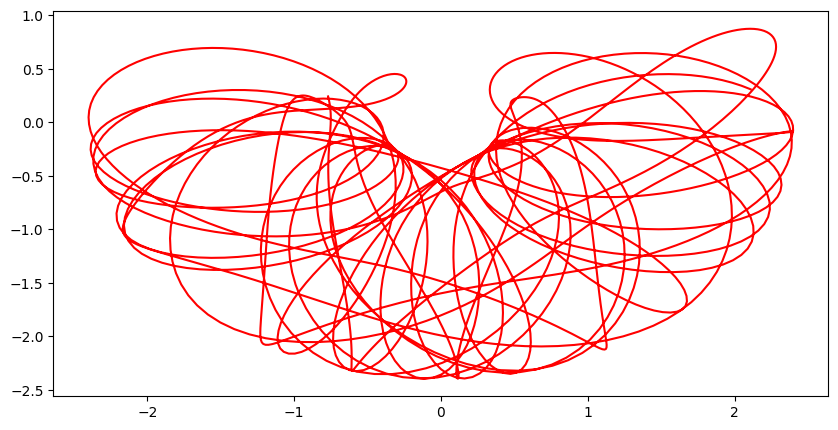

In [11]:
plt.figure(figsize=(10,5))
u0 = sol[:,0]     # theta_1 
u1 = sol[:,1]     # omega 1
u2 = sol[:,2]     # theta_2 
u3 = sol[:,3]     # omega_2 
x1 = L1*np.sin(u0);          # First Pendulum
y1 = -L1*np.cos(u0);
x2 = x1 + L2*np.sin(u2);     # Second Pendulum
y2 = y1 - L2*np.cos(u2);
print(x2[0], y2[0])
plt.plot(x2[0:], y2[0:], color='r')

In [12]:
for i in range(400):
    aleat = np.random.randint(1,400)
    random.seed(aleat)
    indices = random.sample(range(0,2500), 50)
    teste = np.sum(np.array(indices)==0)
    if teste == 1:
        print(aleat)
        print(np.sum(np.array(indices)==0))
        break

357
1


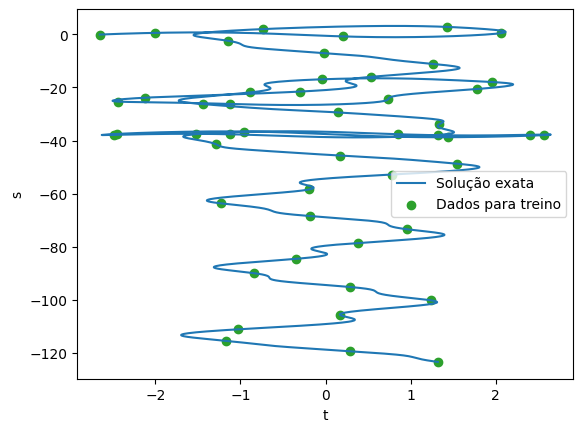

In [13]:
np.random.seed(42)
random.seed(42)
theta_1 = tf.convert_to_tensor(u0,dtype='float32')
theta_1 = tf.expand_dims(theta_1, 1)
theta_2 = tf.convert_to_tensor(u2,dtype='float32')
theta_2 = tf.expand_dims(theta_2, 1)
T = tf.convert_to_tensor(t,dtype='float32')
T = tf.expand_dims(T, 1)
Traj = tf.concat([theta_1,theta_2],axis=1)


n_indices = 50

indices = (np.linspace(1,2500,50,dtype=int)-1)

# dados para treinar a rede do oscilador simples
x_data = tf.gather(T,indices)
y_data = tf.gather(Traj,indices)
ruido_y = tf.random.normal(shape=y_data.shape, mean=0.0, stddev=0.005 * tf.abs(y_data))

y_data_ = y_data + ruido_y

'''x_data = T[0:1000:50]
y_data = Traj[0:1000:50]'''
plt.figure()
plt.plot(theta_1, theta_2, label="Solução exata")
plt.scatter(y_data[:,0],y_data[:,1], color="tab:green", label="Dados para treino")
plt.xlabel('t')
plt.ylabel('s')
plt.legend()
plt.show()

In [10]:
np.min(theta_1)

-2.6516788

In [14]:
# x da EDO, com 150 pontos
x_phys = tf.linspace(0,25,2501)
x_phys = tf.cast(x_phys, tf.float64)
x_phys = tf.expand_dims(x_phys, 1)
#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
learning_rate = 0.00005
epochs = 100000 #uns 780 seg no colab
k_phy_loss1=(1e-1) # coloque zero nesta grandeza para uma FF!
k_phy_loss2=(1e-1)

# Arquiteruta do modelo neural, usando o keras
input_dim = 1
hidden_dim = 256
hidden_dim2 = 128
hidden_dim3 = 64
output_dim = 2

model_keras=tf.keras.Sequential([
    Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    Dense(hidden_dim2, activation='tanh'),
    Dense(hidden_dim3, activation='tanh'),
    Dense(output_dim, activation='linear')
],name='rede_para_PINN')

model_keras.summary()
'''
#Tentativa LSTM
model_keras = Sequential([LSTM(128,input_shape = (1,1), return_sequences=False, use_cudnn=False),
                          Dense(2)])
model_keras.summary()'''

/home/henrique/codigos/tensorflow/tfgpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "rede_para_PINN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,794 (163.26 KB)

 Trainable params: 41,794 (163.26 KB)

 Non-trainable params: 0 (0.00 B)

'\n#Tentativa LSTM\nmodel_keras = Sequential([LSTM(128,input_shape = (1,1), return_sequences=False, use_cudnn=False),\n                          Dense(2)])\nmodel_keras.summary()'

In [12]:
print(y_data.shape)

(50, 2)


In [270]:
model_keras = tf.keras.models.load_model("modelos_de_verdade/PD_caotico_final.keras")
model_keras.summary()

Model: "rede_para_PINN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 256)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,794 (163.26 KB)

 Trainable params: 41,794 (163.26 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
model_keras = tf.keras.models.load_model("modelos_de_verdade/PD_caotico_final_2.keras")

In [ ]:
learning_rate = 0.00001
epochs = 4000000 #uns 780 seg no colab
k_phy_loss1=(1e-3) # coloque zero nesta grandeza para uma FF!
k_phy_loss2=(1e-3)

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
@tf.function
def training_step(x_data,y_data):
    batch_X = x_data
    batch_y = tf.convert_to_tensor(y_data, dtype='float32')
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) #calcula as saidas da rede nos pontos "experimentais"
        data_loss = tf.reduce_mean(tf.square(yh - batch_y))
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(x_phys)
            yhp = model_keras(x_phys) #calcula as saidas da rede nos pontos escolhidos para ajustar a EDO
            dx  = tf.cast((t1.batch_jacobian(yhp, x_phys)),dtype=tf.float32)[:,:,0] # calcula dy/dx que é igual a ds/dt
            dx2 = tf.cast((t1.batch_jacobian(dx, x_phys)),dtype=tf.float32)[:,:,0]
        t1 = yhp[:,0]
        t2 = yhp[:,1]
        w1 = dx[:,0]
        w2 = dx[:,1]
        dw1 = dx2[:,0]
        dw2 = dx2[:,1]
        c = tf.cos(t1-t2)  # intermediate variables
        s = tf.sin(t1-t2)  # intermediate variables
        
        physics1 = tf.reduce_mean(tf.square(dw1-(m2*g*tf.sin(t2)*c - m2*s*(L1*c*w1**2 + L2*w2**2) - (m1+m2)*g*tf.sin(t1) ) /(L1*(m1+m2*s**2))))
        physics2 = tf.reduce_mean(tf.square(dw2-((m1+m2)*(L1*w1**2*s - g*tf.sin(t2) + g*tf.sin(t1)*c) + m2*L2*w2**2*s*c) / (L2 * (m1 + m2*s**2))))
    
        Phys_loss1 = k_phy_loss1*physics1
        Phys_loss2 = k_phy_loss2*physics2 
        data_loss = tf.cast(data_loss, "float32")
        loss =  data_loss + Phys_loss1 + Phys_loss2 
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))
    return Phys_loss1, Phys_loss2, data_loss, loss



In [99]:
start_time = time.time()
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
for epoch in range(epochs):
   loss = training_step(x_data,y_data)
   if ((epoch+1)%1000==0):
      l1,l2,l3,l4 = loss
      h_loss.append(l4)
      h_data_loss.append(l3)
      h_Phys_loss.append(l1+l2)
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l4}, Data Loss: {l3}, Physics Loss: {l1+l2}")
print("--- %s seconds ---" % (time.time() - start_time))
#model_keras.save("modelos_de_verdade/PD_caotico_final.keras")

Epoch 1000/4000000, Loss: 0.002262767404317856, Data Loss: 3.0844283173792064e-05, Physics Loss: 0.0022319231647998095
Epoch 2000/4000000, Loss: 0.002344380132853985, Data Loss: 4.0003214962780476e-05, Physics Loss: 0.0023043768014758825
Epoch 3000/4000000, Loss: 0.002301327884197235, Data Loss: 3.536409349180758e-05, Physics Loss: 0.00226596393622458
Epoch 4000/4000000, Loss: 0.0022863622289150953, Data Loss: 3.360805203556083e-05, Physics Loss: 0.0022527542896568775
Epoch 5000/4000000, Loss: 0.0023167808540165424, Data Loss: 3.973527782363817e-05, Physics Loss: 0.0022770455107092857
Epoch 6000/4000000, Loss: 0.002287146169692278, Data Loss: 3.1344654416898265e-05, Physics Loss: 0.0022558013442903757
Epoch 7000/4000000, Loss: 0.0023397523909807205, Data Loss: 3.951806866098195e-05, Physics Loss: 0.0023002345114946365
Epoch 8000/4000000, Loss: 0.002333202864974737, Data Loss: 3.965190262533724e-05, Physics Loss: 0.0022935508750379086
Epoch 9000/4000000, Loss: 0.0024322476238012314, Dat

KeyboardInterrupt: 

In [86]:
model_keras.save("modelos_de_verdade/PD_caotico_final_2.keras")

Text(0, 0.5, 'loss')

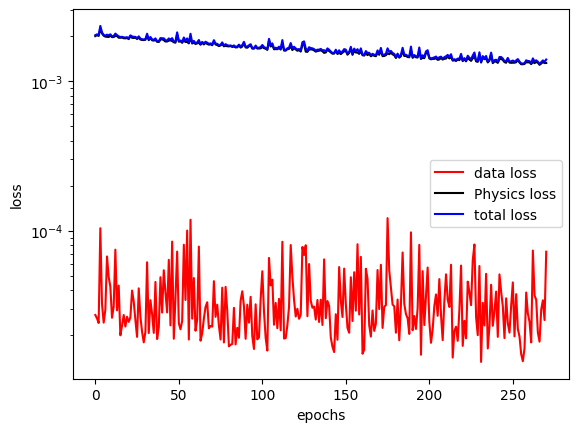

In [76]:
plt.figure()
plt.plot(h_data_loss,'r',label='data loss');
plt.plot(h_Phys_loss,'k',label='Physics loss');
plt.plot(h_loss,'b',label='total loss');
plt.yscale('log')
plt.legend()
plt.xlabel('epochs');plt.ylabel('loss')



In [104]:
prev = np.array(model_keras(T)).reshape(-1,2)
#print(prev)

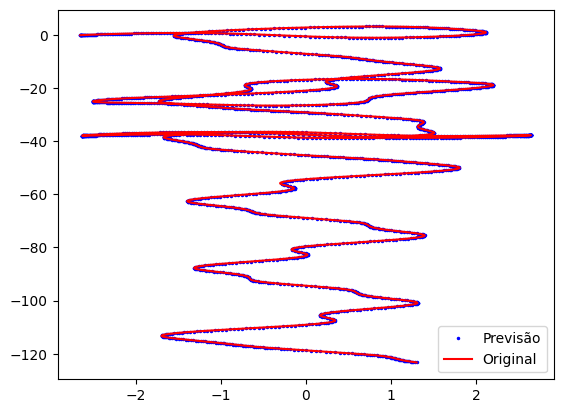

In [105]:
n=000;m=-1
plt.plot(prev[n:m,0],prev[n:m,1],"bo", markersize=1.5, label="Previsão")
plt.plot(theta_1[n:m],theta_2[n:m],"r-",markersize=2.5, label ="Original")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Problema de Avanço do Pêndulo Duplo')

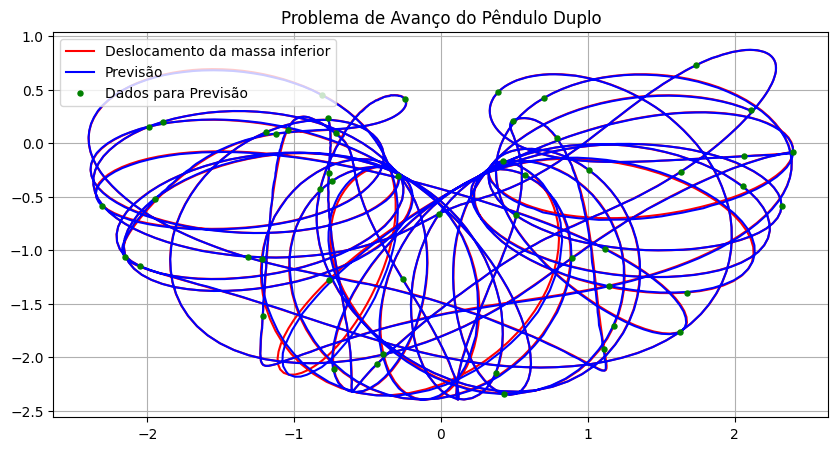

In [109]:
plt.figure(figsize=(10,5))
u0 = sol[:,0]     # theta_1 
u1 = sol[:,1]     # omega 1
u2 = sol[:,2]     # theta_2 
u3 = sol[:,3]     # omega_2 
x1 = L1*np.sin(u0);          # First Pendulum
y1 = -L1*np.cos(u0);
x2 = x1 + L2*np.sin(u2);     # Second Pendulum
y2 = y1 - L2*np.cos(u2);
theta_1_prev = prev[:,0]
theta_2_prev = prev[:,1]
x1_prev = L1*np.sin(theta_1_prev);          # First Pendulum
y1_prev = -L1*np.cos(theta_1_prev);
x2_prev  = x1_prev  + L2*np.sin(theta_2_prev);     # Second Pendulum
y2_prev  = y1_prev  - L2*np.cos(theta_2_prev);

theta1_dados_prev = y_data[:,0]
theta2_dados_prev = y_data[:,1]
x1_dados_prev = L1*np.sin(theta1_dados_prev);          # First Pendulum
y1_dados_prev = -L1*np.cos(theta1_dados_prev);
x2_dados_prev  = x1_dados_prev  + L2*np.sin(theta2_dados_prev);     # Second Pendulum
y2_dados_prev  = y1_dados_prev  - L2*np.cos(theta2_dados_prev);

plt.plot(x2[0:], y2[0:], 'r-',markersize=2.2, label="Deslocamento da massa inferior")
plt.plot(x2_prev,y2_prev,color="b", label="Previsão")
plt.plot(x2_dados_prev,y2_dados_prev,"go",markersize=3.6,label="Dados para Previsão")
plt.grid()
plt.legend()
plt.title("Problema de Avanço do Pêndulo Duplo")
#plt.savefig("Pendulo_duplo.pdf")